In [1]:
import pandas as pd
import numpy as np

import os
import re

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

import keras
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks

from keras.preprocessing import text, sequence

from keras.layers import Dense,Input,LSTM,Bidirectional,Activation,Conv1D,GRU
from keras.layers import Dropout,Embedding,GlobalMaxPooling1D, MaxPooling1D, Add, Flatten
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D

from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import Callback

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

print(keras.__version__)

2.8.0


In [21]:
import pandas as pd

df = pd.read_csv('output.csv', index_col=0)

df.head()

,email,text,4.1,4.2,4.3,4.4,4.5,4.6,4.7,4.8,...,3.4,3.5,3.6,3.7,3.8,3.9,3.10,3.11,3.12,3.13
0,174119,message cut conclusion continue need address k...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,125766,today news weekend follow order year later ene...,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,52167,vince ive hearing rumor decide endorse nodal p...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,221197,jim able provide dan meeting would appreciate ...,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,150202,stan understand completely best achieve desire...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [22]:
X=df["text"]

In [23]:
ylabels = df[['4.1', '4.2', '4.3', '4.4', '4.5', '4.6', '4.7', '4.8', '4.9', '4.10',
       '4.11', '4.12', '4.13', '4.14', '4.15', '4.16', '4.17', '4.18', '4.19',
       '1.1', '1.2', '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '2.1', '2.2',
       '2.3', '2.4', '2.5', '2.6', '2.7', '2.8', '2.9', '2.10', '2.11', '2.12',
       '2.13', '3.1', '3.2', '3.3', '3.4', '3.5', '3.6', '3.7', '3.8', '3.9',
       '3.10', '3.11', '3.12', '3.13']]

In [24]:
X_train,X_test,y_train,y_test = train_test_split(X,ylabels,test_size=0.1,random_state=7)

In [25]:
max_features=13178
max_len=150
sequence_input = Input(shape=(max_len, ))
embed_size=100

In [26]:
tokenizer = text.Tokenizer(
                           num_words = max_features,
                           lower = True
                          )

tokenizer.fit_on_texts(list(X_train)+list(X_test))

X_train=tokenizer.texts_to_sequences(X_train)
X_test=tokenizer.texts_to_sequences(X_test)

X_train=sequence.pad_sequences(X_train,maxlen=max_len)
X_test=sequence.pad_sequences(X_test,maxlen=max_len)

In [8]:
glove_6B_100d_index = {}

In [9]:
glove_6B_100d = "/content/gdrive/MyDrive/glove.6B.100d.txt"

In [10]:
with open(glove_6B_100d, encoding='utf8') as file:
    for line in file:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_6B_100d_index[word] = coefs

In [11]:
word_index = tokenizer.word_index
#prepare embedding matrix
num_words = min(max_features, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embed_size))
for word, i in word_index.items():
    if i >= max_features:
        continue
    embedding_vector = glove_6B_100d_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [14]:
layer = Embedding(max_features, 
                  embed_size, 
                  weights=[embedding_matrix], 
                  trainable = False
                  )(sequence_input)

layer = SpatialDropout1D(0.2)(layer)

layer = Bidirectional(GRU(128, 
                          return_sequences=True, 
                          dropout=0.1, 
                          recurrent_dropout=0.1)
                      )(layer)

layer = Conv1D(64, kernel_size = 3, 
               padding = "valid", 
               kernel_initializer = "glorot_uniform"
               )(layer)

avg_pool = GlobalAveragePooling1D()(layer)

max_pool = GlobalMaxPooling1D()(layer)

layer = concatenate([avg_pool, max_pool]) 

preds = Dense(53, activation="sigmoid")(layer)

model = Model(sequence_input, preds)

model.compile(loss='binary_crossentropy',optimizer=Adam(lr=1e-3),metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [15]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 150, 100)     1317800     ['input_2[0][0]']                
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 150, 100)    0           ['embedding_1[0][0]']            
 out1D)                                                                                           
                                                                                                  
 bidirectional (Bidirectional)  (None, 150, 256)     176640      ['spatial_dropout1d[0][0]']  

In [27]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)

In [28]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)


(1005, 150)
(112, 150)
(125, 150)


In [30]:
history = model.fit(X_train, 
                    y_train, 
                    batch_size=128, 
                    epochs=10, 
                    validation_data=(X_val, y_val))

Epoch 1/10
8/8 [==============================] - 12s 1s/step - loss: 0.1481 - accuracy: 0.2896 - val_loss: 0.1693 - val_accuracy: 0.3125
Epoch 2/10
8/8 [==============================] - 17s 2s/step - loss: 0.1463 - accuracy: 0.2876 - val_loss: 0.1671 - val_accuracy: 0.3393
Epoch 3/10
8/8 [==============================] - 13s 2s/step - loss: 0.1453 - accuracy: 0.2806 - val_loss: 0.1653 - val_accuracy: 0.3929
Epoch 4/10
8/8 [==============================] - 12s 1s/step - loss: 0.1431 - accuracy: 0.3313 - val_loss: 0.1665 - val_accuracy: 0.3125
Epoch 5/10
8/8 [==============================] - 12s 1s/step - loss: 0.1412 - accuracy: 0.3184 - val_loss: 0.1644 - val_accuracy: 0.3036
Epoch 6/10
8/8 [==============================] - 12s 2s/step - loss: 0.1401 - accuracy: 0.3264 - val_loss: 0.1635 - val_accuracy: 0.3571
Epoch 7/10
8/8 [==============================] - 12s 1s/step - loss: 0.1379 - accuracy: 0.3194 - val_loss: 0.1626 - val_accuracy: 0.3839
Epoch 8/10
8/8 [==================

In [31]:
hist_df = pd.DataFrame(history.history)
hist_df.head(10)

,loss,accuracy,val_loss,val_accuracy
0,0.148076,0.289552,0.169285,0.312500
1,0.146319,0.287562,0.167128,0.339286
2,0.145310,0.280597,0.165270,0.392857
3,0.143061,0.331343,0.166512,0.312500
4,0.141156,0.318408,0.164359,0.303571
5,0.140118,0.326368,0.163457,0.357143
6,0.137886,0.319403,0.162619,0.383929
7,0.137194,0.337313,0.161499,0.392857
8,0.136474,0.333333,0.161677,0.366071
9,0.133835,0.335323,0.161316,0.401786


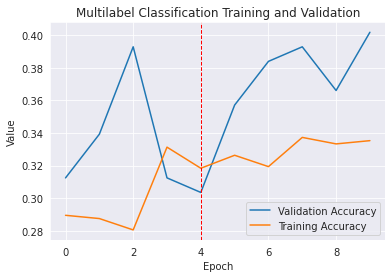

In [32]:
import matplotlib.pyplot as plt

plt.clf()
plt.plot(hist_df['val_accuracy'], label='Validation Accuracy')
plt.plot(hist_df['accuracy'], label='Training Accuracy')
plt.axvline(x = 4, linewidth=1, color='r', linestyle = "--")

plt.title('Multilabel Classification Training and Validation')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()